In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '340909',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/bwABghR3MhsmGJqyh42WXQ__thumb/img/is-GKWwws4rDrIe-B9fbuM_oBYA=/fit-in/200x150/filters:strip_icc()/pic6235824.png',
  'name': "Gloomholdin'",
  'yearpublished': '2021'},
 {'id': '341048',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/cs7Oby2YsVe-lcP65FdXgQ__thumb/img/v2UqsOmM4S29dr5LGVNgvwnHJWc=/fit-in/200x150/filters:strip_icc()/pic6240235.jpg',
  'name': 'Free Ride',
  'yearpublished': '2021'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,340909,051276,N/A,Print & Play version
1,340909,archaiopaichnidi,N/A,Free PnP files: https://boardgamegeek.com/boar...
2,340909,CKHarlin,N/A,I am SUPER excited about this! Is there anyway...
3,340909,deagledryan,N/A,Printed
4,340909,DustinHendrickson,10.0,PnP
...,...,...,...,...
126331,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
126332,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
126333,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
126334,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 19935 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9.0        19859
8.0        19104
10.0       17926
7.0        10264
N/A         7948
           ...  
4.66           1
7.0985         1
2.3            1
4.21           1
8.26667        1
Name: rating, Length: 619, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(98453, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(7948, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'best: 4 good: 2 good: 3 good: 5 '

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Juego divertido. Un push your luck de toda la vida donde debes intentar hacer más puntos que los demás. Es un juego divertido. Si tienes ocasión de repetir dale con tranquilidad. Creo que pueda ser buen juego para los novatos. Comprado en Aleman con intención de tradumaquetearlo todo por solo 23€!!!'

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
49/49 - 5s - loss: 0.5271 - accuracy: 0.8300 - val_loss: 0.4486 - val_accuracy: 0.8562
Epoch 2/100
49/49 - 3s - loss: 0.3894 - accuracy: 0.8595 - val_loss: 0.3616 - val_accuracy: 0.8613
Epoch 3/100
49/49 - 3s - loss: 0.3172 - accuracy: 0.8741 - val_loss: 0.3265 - val_accuracy: 0.8738
Epoch 4/100
49/49 - 3s - loss: 0.2749 - accuracy: 0.8927 - val_loss: 0.3117 - val_accuracy: 0.8798
Epoch 5/100
49/49 - 3s - loss: 0.2449 - accuracy: 0.9039 - val_loss: 0.3101 - val_accuracy: 0.8810
Epoch 6/100
49/49 - 3s - loss: 0.2209 - accuracy: 0.9132 - val_loss: 0.3109 - val_accuracy: 0.8775
Epoch 7/100
49/49 - 3s - loss: 0.2013 - accuracy: 0.9217 - val_loss: 0.3194 - val_accuracy: 0.8776
Epoch 8/100
49/49 - 3s - loss: 0.1843 - accuracy: 0.9302 - val_loss: 0.3301 - val_accuracy: 0.8723
Epoch 9/100
49/49 - 3s - loss: 0.1702 - accuracy: 0.9363 - val_loss: 0.3443 - val_accuracy: 0.8710
Epoch 10/100
49/49 - 3s - loss: 0.1578 - accuracy: 0.9424 - val_loss: 0.3606 - val_accuracy: 0.8679
33/33 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000026A8F412D30>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

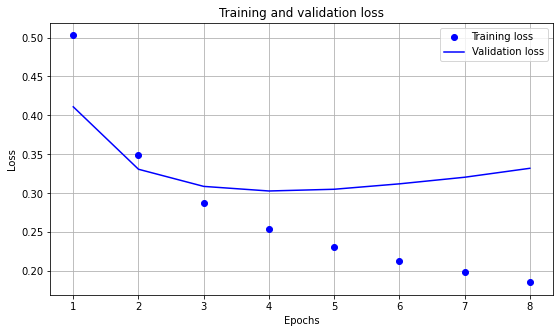

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

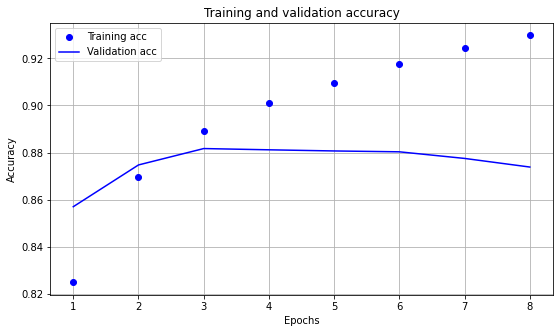

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"best: 4 good: 2 good: 3 good: 5 "
score: 1.000000
actual: 1

input:
"Juego divertido. Un push your luck de toda la vida donde debes intentar hacer más puntos que los demás. Es un juego divertido. Si tienes ocasión de repetir dale con tranquilidad. Creo que pueda ser buen juego para los novatos. Comprado en Aleman con intención de tradumaquetearlo todo por solo 23€!!!"
score: 1.000000
actual: 0

input:
"Retains most of the flow and and play of the third edition. Especially with the shattered empire addition. Most of the changes are for the better some I particularly liked Simplification of tech tree, the dependencies are on the number of techs not specific ones.  Ships can be enhanced as part of technology. Pulling out the voting to a separate phase is nice.   Still ambivalent about trade - I like the new methodology but it can slow the game down.  Will I buy the new edition. Probably not, I'll be happy to play other peoples copies, it one isn't available my 3rd edition is still

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

8/8 - 0s
input:
"Fell in love with the theme at first sight, my first even-a-bit heavier game. Have yet to try Turmoil..."
score: 1.000000

input:
"Tokaido for multiplayer journey or Lord's of Waterdeep. Gather this is super pretty and okay but there are other games better."
score: 0.000000

input:
"Verjaardagscadeau van Edmee uit Amsterdam"
score: 1.000000

input:
"New in Shrink (includes Swift Start pack/Automa)"
score: 1.000000

input:
"Highly played, too popular to get for cheap though."
score: 0.000000

input:
"Should be amazing if just a reprint"
score: 1.000000

input:
"2 player co-op, campaign style, must build deck first"
score: 1.000000

input:
"man i wish i could get this behemoth to the table more often"
score: 1.000000

input:
"b1-2 Coop Campaign (! Digital Hybrid, App Required )"
score: 1.000000

input:
"Jeu complexe populaire... à regarder?"
score: 1.000000


## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026F1BFC0E50>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.15


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.05


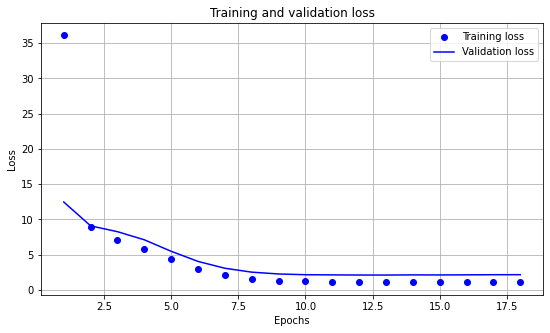

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

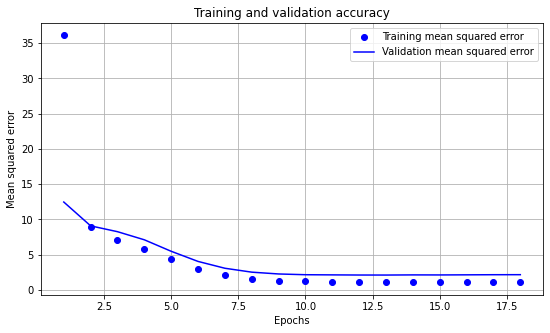

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"best: 4 good: 2 good: 3 good: 5 "
score: 8.87
actual: 9.00 

input: 
"Juego divertido. Un push your luck de toda la vida donde debes intentar hacer más puntos que los demás. Es un juego divertido. Si tienes ocasión de repetir dale con tranquilidad. Creo que pueda ser buen juego para los novatos. Comprado en Aleman con intención de tradumaquetearlo todo por solo 23€!!!"
score: 6.76
actual: 6.60 

input: 
"Retains most of the flow and and play of the third edition. Especially with the shattered empire addition. Most of the changes are for the better some I particularly liked Simplification of tech tree, the dependencies are on the number of techs not specific ones.  Ships can be enhanced as part of technology. Pulling out the voting to a separate phase is nice.   Still ambivalent about trade - I like the new methodology but it can slow the game down.  Will I buy the new edition. Probably not, I'll be happy to play other peoples copies, it one isn't available my 3rd edition is st

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Looks neat, too expensive though for what you appear to get."
    reg score: 6.24
    clf score: 0

"After one half-finished play. Wow! Variable board and tech tracks are compelling. Hard decisions fueled by a challenging and tough to math-out strategy, given the plentiful options and the changing game state. More please."
    reg score: 9.06
    clf score: 1

"1-6 players Best with 3–4 players  Card sleeved"
    reg score: 9.07
    clf score: 1

"+ Colonies + Hellas & Elysium + Prelude + Turmoil + Venus Next"
    reg score: 9.24
    clf score: 1

"Funciona bien a 2 Imprescindible expansión???"
    reg score: 7.21
    clf score: 1

"+Hero standees +Removable stickers"
    reg score: 9.66
    clf score: 1

"Gift from my BGG Secret Santa 2018. Thanks Santa! "
    reg score: 8.54
    clf score: 1

"This game is a suppose to be a GODsend. Without playing this I still feel like Diplomacy will reamain the better game because of the ease of play. TI4 is notorious for being overly complex and

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
|  84876.00 |          8.10 |        6583.00 |
| 124361.00 |          8.19 |        3884.00 |
| 155821.00 |          7.91 |        1788.00 |
| 162886.00 |          8.36 |        3586.00 |
| 167355.00 |          8.41 |        1890.00 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
|  84876.00 |          8.07 |         360.00 |
| 124361.00 |          8.08 |         254.00 |
| 155821.00 |          8.00 |         152.00 |
| 162886.00 |          8.18 |         320.00 |
| 167355.00 |          8.36 |         212.00 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/bwABghR...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.173309,8.903985,1,2021
1,"<img src=""https://cf.geekdo-images.com/cs7Oby2...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,NaN,NaN,2,2021
2,"<img src=""https://cf.geekdo-images.com/fW43z5X...","<a href=""https://boardgamegeek.com/boardgame/3...",5.839837,7.716744,6.427026,3,2021
3,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.087194,8.022999,8.081427,4,2020
4,"<img src=""https://cf.geekdo-images.com/KTKXgGG...","<a href=""https://boardgamegeek.com/boardgame/3...",8.160000,5.152701,7.658784,5,2021


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',10.000000,8.173309,8.903985,1,2021
2,,Free Ride,NaN,NaN,NaN,2,2021
3,,Terraforming Mars: Ares Expedition,5.839837,7.716744,6.427026,3,2021
4,,Dune: Imperium,8.087194,8.022999,8.081427,4,2020
5,,The Goonies: Never Say Die,8.160000,5.152701,7.658784,5,2021


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',10.000000,8.173309,8.903985,1,2021
2,,6: Siege – The Board Game,8.800000,9.392964,9.022362,18,2022
3,,Eclipse: Second Dawn for the Galaxy,8.720660,8.017183,8.615202,35,2020
4,,Middara: Unintentional Malum – Act 1,8.675117,8.387183,8.610939,50,2019
5,,Brass: Birmingham,8.670216,8.220646,8.630205,22,2018


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,6: Siege – The Board Game,8.800000,9.392964,9.022362,18,2022
2,,Gloomholdin',10.000000,8.173309,8.903985,1,2021
3,,Brass: Birmingham,8.670216,8.220646,8.630205,22,2018
4,,Eclipse: Second Dawn for the Galaxy,8.720660,8.017183,8.615202,35,2020
5,,Middara: Unintentional Malum – Act 1,8.675117,8.387183,8.610939,50,2019


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Really good trick taking game.  Unfortunately, I discovered very shortly afterwards that the rest of the family doesn’t do trick taking games!"
score: 5.04

"Juego que por temática me apetece tener ademas está bastante alto en la BGG siendo que acaba de salir. "
score: 5.88

"Card Drafting Contracts Modular Board Set Collection Solo / Solitaire Game Track Movement Turn Order: Claim Action Worker Placement"
score: 6.17

"Cons: Long, complex, multiplayer. Might make a good online play or PBEM, but there are other games to which I would rather devote my time."
score: 6.85

"A premium adventure game based on dice rolling with character progression. Unfortunately, the price tag is way too high!!!"
score: 7.06

"Need to play with experienced opponents after playing multiple times with other newbies being taught by incompetent teacher.   Can't help but be concerned by number of aspects of game, and the stock photo card art doesn't reassure me."
score: 7.32

"Haven't played too much, but espe

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test